In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random

In [2]:
""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

<img src="qb.png" alt="drawing" width="500"/>

In [3]:
def raising_coeff(Fe, Fg, me, mg, Je, Jg):
    I = 1/2 #nuclear spin
    q = me-mg
    cg = CG(Fg, mg, 1, q , Fe, me) #Clebsh-Gordan coeff
    return (float(cg.doit()) 
            * (-1)**(Fg+Je+1+I) 
            * np.sqrt((2*Fg+1)*(2*Je+1)) 
            * float(wigner_6j(Je, Jg, 1, Fg, Fe, I))   
            )

In [4]:
CG(1/2, -1/2, 1, 1 , 3/2, 1/2).doit()

0.333333333333333*sqrt(3)

In [5]:
def Rabi(Fg, mFg, Jg, Fe, mFe, Je, intensity, tau, omega):
    
    return (np.sqrt(2*intensity/epsilon0/c)
            *np.sqrt(3*np.pi*epsilon0*hbar*c**3/tau/omega**3)
            *raising_coeff(Fe, Fg, mFe, mFg, Je, Jg)
            /hbar
           )

In [6]:
_lambda = 556e-9
omega_r = 2*np.pi*137e3
m = 171*u
omega =  2*np.pi*(4760.247 + 539385645.457)*1e6 #https://journals.aps.org/pra/pdf/10.1103/PhysRevA.100.042505
tau = 866.1e-9

In [7]:
1/4/170e-9/1e6

1.4705882352941178

In [8]:
wp_1 = 0.22e-3
wp_2 = 1.1e-3
ws_1 = 0.22e-3
ws_2 = 1.1e-3
Ps = 32e-3
Pp = 9.4e-3
Ip = 2*Pp/np.pi/wp_1/wp_2
Is = 2*Ps/np.pi/ws_1/ws_2

Delta_minus = -2*np.pi*42e6 * 0.3/3.5
Delta_e2 = -2*np.pi*14e6 * 0.3/3.5
Delta_e3 = 2*np.pi*16e6 * 0.3/3.5
Delta_plus = 2*np.pi*48e6 * 0.3/3.5

Delta = -2*np.pi*180e6 #detuning from the free space resonance

Omega_p = Rabi(1/2, 1/2, 0, 3/2, 1/2, 1, Ip, tau, omega)
Omega_s = Rabi(1/2, -1/2, 0, 3/2, 1/2, 1, Is, tau, omega)

print(Omega_s)

#print('Single Rabi:\n pi ', Omega_p/2/np.pi/1e6, 'MHz \n sigma ', Omega_s/2/np.pi/1e6, 'MHz')
print('approx Raman:', abs(Omega_p*Omega_s/2/(Delta+Delta_e3)/2/np.pi/1e3)+abs(Omega_p*Omega_s/2/(Delta-Delta_e2)/2/np.pi/1e3), 'kHz')

115630199.9128249
approx Raman: 1452.5382646650646 kHz


In [9]:
def light_shift(mFg, mFe, I, delta):
    Omega = Rabi(1/2, mFg, 0, 3/2, mFe, 1, I, tau, omega)
    return Omega**2/4/delta

In [10]:
Ps = 32e-3
Pp = 9.4e-3
Ip = 2*Pp/np.pi/wp_1/wp_2
Is = 2*Ps/np.pi/ws_1/ws_2

L1 = (light_shift(-1/2, -3/2, Is, Delta-Delta_minus) 
      + light_shift(-1/2, -1/2, Ip, Delta-Delta_e2) 
      + light_shift(-1/2, 1/2, Is, Delta-Delta_e3))
L2 = (light_shift(1/2, 3/2, Is, Delta-Delta_plus) 
      + light_shift(1/2, 1/2, Ip, Delta-Delta_e3) 
      + light_shift(1/2, -1/2, Is, Delta-Delta_e2))

Omega_p = Rabi(1/2, 1/2, 0, 3/2, 1/2, 1, Ip, tau, omega)
Omega_s = Rabi(1/2, -1/2, 0, 3/2, 1/2, 1, Is, tau, omega)

OmegaR = abs(Omega_p*Omega_s/2/Delta)
print((L1-L2)/2/np.pi/1e3)

-57.563440072996244


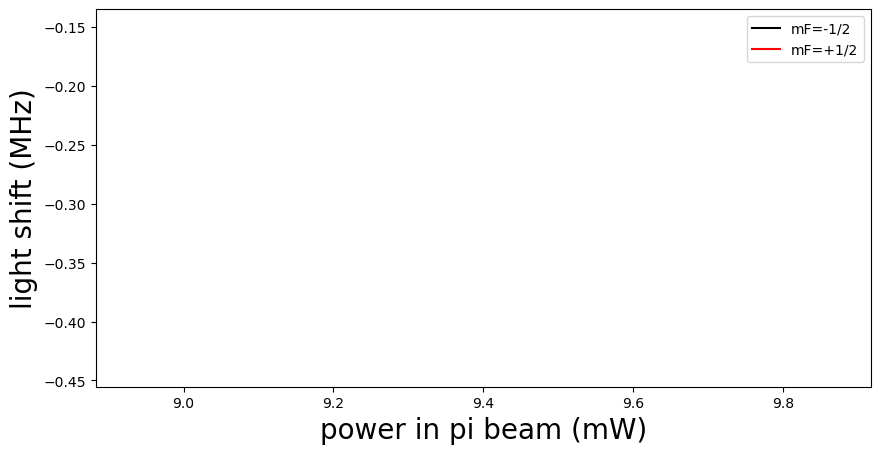

In [14]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(Pp*1e3, L1/1e6, color='k', linestyle='-', label = 'mF=-1/2')
axes.plot(Pp*1e3, L2/1e6, color='r', linestyle='-', label = 'mF=+1/2')
axes.set_xlabel(r'power in pi beam (mW)', fontsize=20)
axes.set_ylabel(r'light shift (MHz)', fontsize=20)
plt.legend()

In [17]:
L1

-149530.1065404948

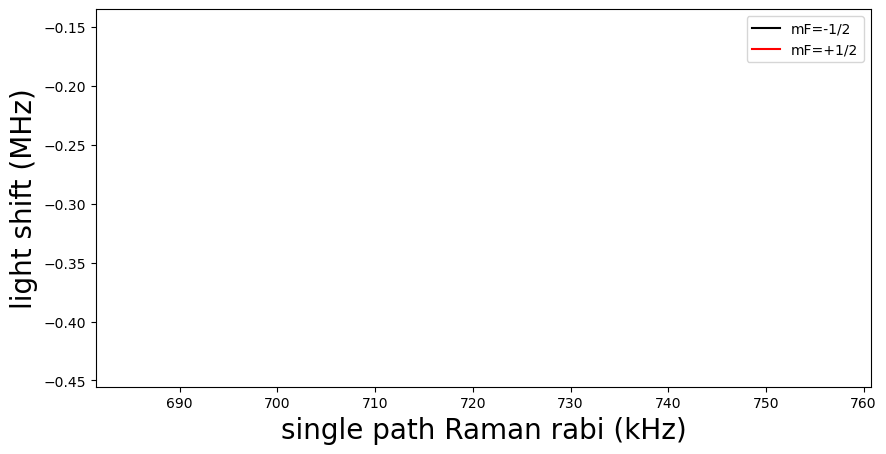

In [15]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(OmegaR/2/np.pi/1e3, L1/1e6, color='k', linestyle='-', label = 'mF=-1/2')
axes.plot(OmegaR/2/np.pi/1e3, L2/1e6, color='r', linestyle='-', label = 'mF=+1/2')
axes.set_xlabel(r'single path Raman rabi (kHz)', fontsize=20)
axes.set_ylabel(r'light shift (MHz)', fontsize=20)
plt.legend()

Text(0, 0.5, 'ground state splitting (kHz)')

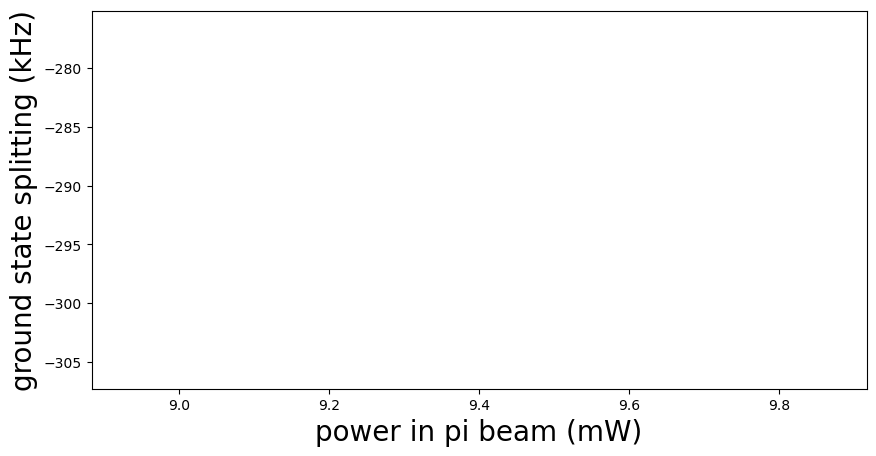

In [18]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(Pp*1e3, np.add((L2-L1), 16)/1e3, color='k', linestyle='-')

axes.set_xlabel(r'power in pi beam (mW)', fontsize=20)
axes.set_ylabel(r'ground state splitting (kHz)', fontsize=20)

Text(0, 0.5, 'ground state splitting (kHz)')

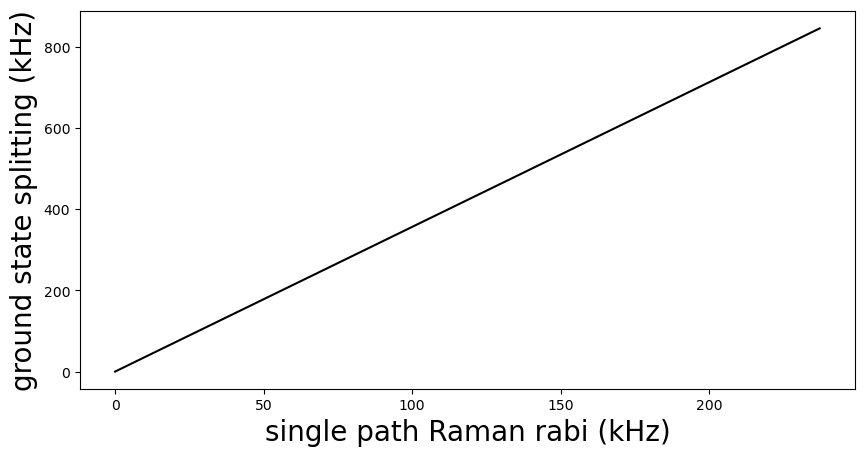

In [38]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(OmegaR/2/np.pi/1e3, np.add((L2-L1), 16)/1e3, color='k', linestyle='-')

axes.set_xlabel(r'single path Raman rabi (kHz)', fontsize=20)
axes.set_ylabel(r'ground state splitting (kHz)', fontsize=20)

In [13]:
ws = 1e-3
Delta = -2*np.pi*160e6
Ps = 6e-3
Is = 2*Ps/np.pi/ws**2

L1 = (light_shift(-1/2, 1/2, Is, Delta-1.5e6*6))
L2 = (light_shift(1/2, 3/2, Is, Delta-4.5*6e6))

Omega_p = Rabi(1/2, 1/2, 0, 3/2, 1/2, 1, Ip, tau, omega)
Omega_s = Rabi(1/2, -1/2, 0, 3/2, 1/2, 1, Is, tau, omega)

print((L1-L2)/2/np.pi/1e3)
print(L1, L2)

46.35201669616886
-149530.1065404948 -440768.4168040058
